In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [4]:
data_all = pd.read_csv("../la_crime_cleaned.csv")

In [21]:
def temporal_motifs(data_all):
    # No need to sample since you're using the whole dataset
    # Sort the data based on the date_occured
    sorted_df = data_all.sort_values(by=['date_occured'])

    # Initialize transitions list
    transitions = []
    
    # Get unique dates
    unique_dates = sorted_df['date_occured'].unique()
    
    # Iterate over each unique date except the last one
    for i in range(len(unique_dates) - 1):
        curr_date = unique_dates[i]
        next_date = unique_dates[i + 1]
        # print(curr_date, next_date)
        
        # Get crime descriptions for the current and next day
        curr_day_df = sorted_df[sorted_df['date_occured'] == curr_date]
        next_day_df = sorted_df[sorted_df['date_occured'] == next_date]

        # For each crime on the current day, count how many times it is followed by each crime on the next day
        for curr_crime in curr_day_df['crime_code_description'].unique():
            curr_crime_count = curr_day_df[curr_day_df['crime_code_description'] == curr_crime].shape[0]
            for next_crime in next_day_df['crime_code_description'].unique():
                next_crime_count = next_day_df[next_day_df['crime_code_description'] == next_crime].shape[0]
                transitions.append((curr_crime, next_crime, min(curr_crime_count, next_crime_count)))
    
    # Create a DataFrame from the transitions list
    transitions_df = pd.DataFrame(transitions, columns=['Source', 'Target', 'weight'])

    # Sum the counts for each transition
    transitions_sum_df = transitions_df.groupby(['Source', 'Target']).sum().reset_index()

    # Save the edges to a CSV file
    transitions_sum_df.to_csv('temporal_crime_pattern_edges.csv', index=False)
    
    # Create a nodes dataframe and save to a CSV file
    nodes = pd.DataFrame(list(set(transitions_sum_df['Source']).union(set(transitions_sum_df['Target']))), columns=['id'])
    nodes.to_csv('temporal_crime_pattern_nodes.csv', index=False)
    
    return transitions_sum_df, nodes

In [ ]:
transitions_sum_df, nodes = temporal_motifs(data_all)

In [31]:
def get_statistics(csv, percentage):
    
    edges = pd.read_csv(csv)
    
    G1 = nx.from_pandas_edgelist(edges, source='Source', target='Target', edge_attr='weight', create_using=nx.DiGraph())
    G1.remove_edges_from(nx.selfloop_edges(G1))
        
    degrees = [d for n, d in G1.degree()]
    plt.hist(degrees, bins=100)
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title("Degree Distribution")
    plt.savefig(f"temporal_degree_distribution_{percentage}.png")
    
    print("Number of nodes: ", G1.number_of_nodes())
    print("Number of edges: ", G1.number_of_edges())
    print("Average degree: ", np.mean(degrees))
    print("Average in-degree: ", np.mean([d for n, d in G1.in_degree()]))
    print("Average out-degree: ", np.mean([d for n, d in G1.out_degree()]))
    print("Average clustering coefficient: ", nx.average_clustering(G1))
    print("Global clustering coefficient: ", nx.transitivity(G1))
    print("Average shortest path length: ", nx.average_shortest_path_length(G1))
    print("Diameter: ", nx.diameter(G1))
    
    # vertex connectivity of the network
    print("Vertex connectivity: ", nx.node_connectivity(G1))
    # edge connectivity of the network
    print("Edge connectivity: ", nx.edge_connectivity(G1))
    
    k_core = nx.k_core(G1)
    print("Largest edge-connectivity with k-core approach: ", nx.edge_connectivity(k_core))
    print("Number of nodes in the largest k-core: ", k_core.number_of_nodes())
    print("Vertex connectivity of the largest k-core: ", nx.node_connectivity(k_core))
    
    degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence
    degreeCount = dict()
    for d in degree_sequence:
        if d not in degreeCount:
            degreeCount[d] = 1
        else:
            degreeCount[d] += 1
    degree, count = zip(*degreeCount.items())
    total_nodes = G1.number_of_nodes()
    probabilities = [c/total_nodes for c in count]
    plt.plot(degree, probabilities, 'bo')
    plt.xlabel('Degree k')
    plt.ylabel('Count of Degree = k')
    plt.title(f'Degree Distribution {percentage*100}% of Data')
    plt.savefig(f'Degree_Distribution_{percentage}.png')
    plt.close()
    return G1

In [64]:
G1 = get_statistics('temporal_crime_pattern_edges.csv', 1)

Number of nodes:  135
Number of edges:  16415
Average degree:  243.1851851851852
Average in-degree:  121.5925925925926
Average out-degree:  121.5925925925926
Average clustering coefficient:  0.9433330962944189
Global clustering coefficient:  0.9357236567416698
Average shortest path length:  1.0925925925925926
Diameter:  2
Vertex connectivity:  48
Edge connectivity:  43
Largest edge-connectivity with k-core approach:  102
Number of nodes in the largest k-core:  113
Vertex connectivity of the largest k-core:  102


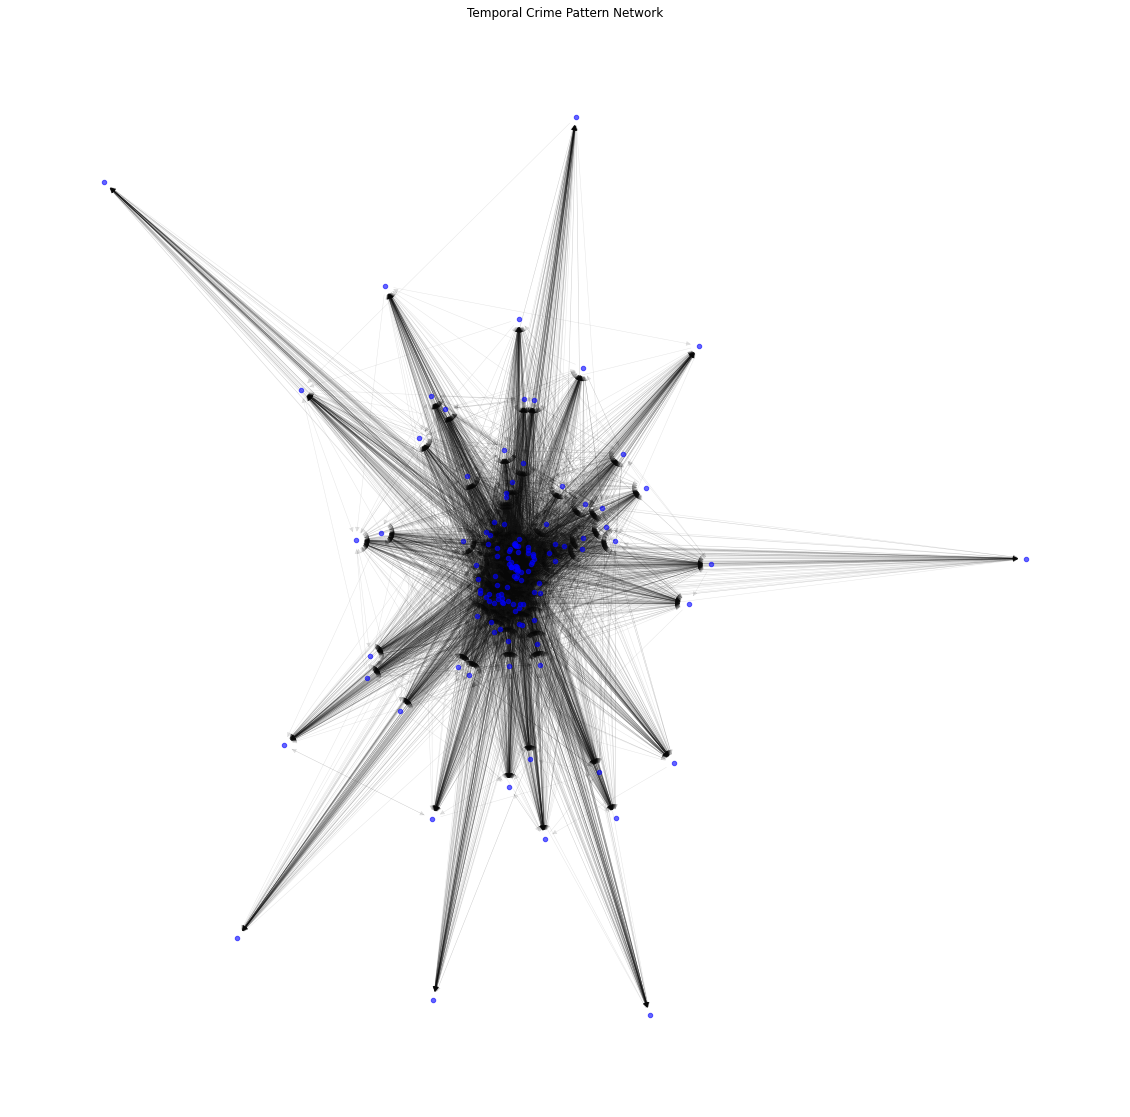

In [33]:
pos = nx.spring_layout(G1, k=0.15, iterations=20)

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G1, pos, node_size=20, alpha=0.6, node_color="blue")

nx.draw_networkx_edges(G1, pos, alpha=0.1, width=0.5)

plt.title("Temporal Crime Pattern Network")

plt.axis("off")
plt.savefig(f'Temporal_Network.png')
# save as gexf
nx.write_gexf(G1, "Temporal_Network.gexf") 

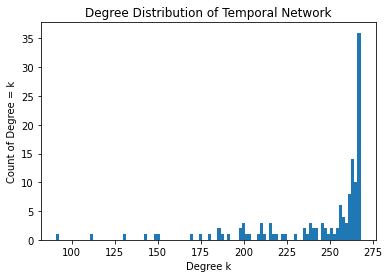

In [79]:
edges = pd.read_csv("temporal_crime_pattern_edges.csv")

G1 = nx.from_pandas_edgelist(edges, source='Source', target='Target', edge_attr='weight', create_using=nx.DiGraph())
G1.remove_edges_from(nx.selfloop_edges(G1))
    
degrees = [d for n, d in G1.degree()]
plt.hist(degrees, bins=100)
plt.xlabel('Degree k')
plt.ylabel('Count of Degree = k')
plt.title("Degree Distribution of Temporal Network")
plt.savefig(f"temporal_degree_distribution.png")

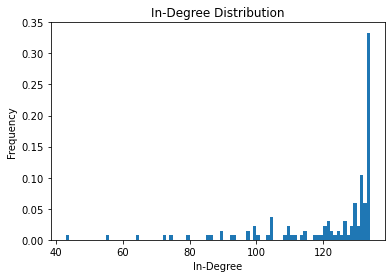

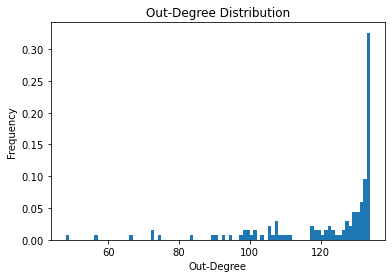

In [34]:
in_degrees = G1.in_degree()
out_degrees = G1.out_degree()

# Plotting the in-degree distribution
in_degree_values = [d for n, d in in_degrees]
plt.hist(in_degree_values, bins=range(min(in_degree_values), max(in_degree_values) + 1, 1), density=True)
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.show()

# Plotting the out-degree distribution
out_degree_values = [d for n, d in out_degrees]
plt.hist(out_degree_values, bins=range(min(out_degree_values), max(out_degree_values) + 1, 1), density=True)
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.show()

In [36]:
# top 10 nodes with highest betweenness centrality
sorted_edges = sorted(G1.edges(data=True), key=lambda x: x[2].get('weight', 1), reverse=True)
top_10_connections = sorted_edges[:10]
top_transitions = []
for connection in top_10_connections:
    source = connection[0]
    target = connection[1]
    weight = connection[2]['weight']
    top_transitions.append((source, target))
    print(f"The connection from {source} to {target} has a weight of {weight}.")

The connection from Burglary From Vehicle to Battery - Simple Assault has a weight of 115230.
The connection from Vehicle - Stolen to Battery - Simple Assault has a weight of 114938.
The connection from Battery - Simple Assault to Burglary From Vehicle has a weight of 114883.
The connection from Battery - Simple Assault to Vehicle - Stolen has a weight of 114529.
The connection from Theft Plain - Petty ($950 & Under) to Battery - Simple Assault has a weight of 110000.
The connection from Burglary to Battery - Simple Assault has a weight of 109685.
The connection from Battery - Simple Assault to Theft Plain - Petty ($950 & Under) has a weight of 109258.
The connection from Vehicle - Stolen to Burglary From Vehicle has a weight of 108802.
The connection from Burglary From Vehicle to Vehicle - Stolen has a weight of 108793.
The connection from Battery - Simple Assault to Burglary has a weight of 108379.


In [46]:
data_all['date_occured'] = pd.to_datetime(data_all['date_occured'])

# Filter the data for the 'Burglary From Vehicle' events
burglary_df = data_all[data_all['crime_code_description'] == 'Burglary From Vehicle']

# Create a Series with dates incremented by one day
next_day = burglary_df['date_occured'] + pd.Timedelta(days=1)

# Filter the data for 'Battery - Simple Assault' events that occurred the day after a 'Burglary From Vehicle'
battery_df = data_all[(data_all['crime_code_description'] == 'Battery - Simple Assault') & 
                (data_all['date_occured'].isin(next_day))]

In [47]:
# Group by area and count occurrences for both crime types
burglary_by_area = burglary_df.groupby('area_name').size().reset_index(name='burglary_counts')
battery_by_area = battery_df.groupby('area_name').size().reset_index(name='battery_counts')

# Merge the two dataframes on area_name
area_counts = pd.merge(burglary_by_area, battery_by_area, on='area_name', how='outer').fillna(0)

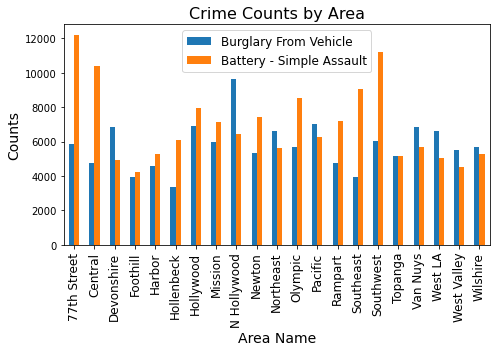

In [62]:
# Plot the counts for both crime types by area
area_counts.plot(x='area_name', y=['burglary_counts', 'battery_counts'], kind='bar', figsize=(7, 5))
plt.title('Crime Counts by Area', fontsize=16)
plt.xlabel('Area Name', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=90, fontsize=12)  # Rotate the x-labels by 90 degrees
plt.legend(['Burglary From Vehicle', 'Battery - Simple Assault'], fontsize=12)
plt.tight_layout()
plt.savefig('crime_counts_by_area.png', dpi=300)


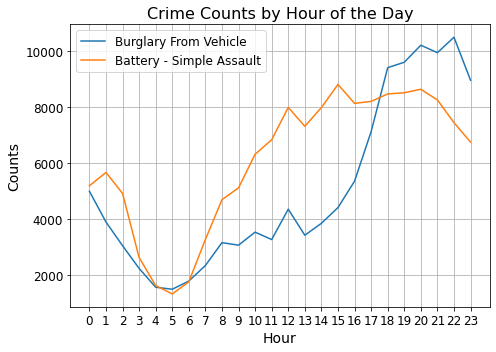

In [59]:
# Plot the counts of 'Burglary From Vehicle' by hour of the day
burglary_by_hour = burglary_df.groupby('hour').size().reset_index(name='counts')
battery_by_hour = battery_df.groupby('hour').size().reset_index(name='counts')

plt.figure(figsize=(7, 5))  # Adjust the figure size as per your requirement
plt.plot(burglary_by_hour['hour'], burglary_by_hour['counts'], label='Burglary From Vehicle')
plt.plot(battery_by_hour['hour'], battery_by_hour['counts'], label='Battery - Simple Assault')
plt.title('Crime Counts by Hour of the Day', fontsize=16)  # Increase the font size of the title
plt.xlabel('Hour', fontsize=14)  # Increase the font size of the x-axis label
plt.ylabel('Counts', fontsize=14)  # Increase the font size of the y-axis label
# increase the font size of the tick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xticks(range(0, 24))
plt.legend(fontsize=12)  # Increase the font size of the legend
plt.grid(True)
plt.tight_layout()  # Adjust the spacing between the plot elements
plt.savefig('crime_counts_by_hour.png', dpi=1000)  # Increase the dpi for higher resolution


In [63]:
# Get the degrees of all nodes in the graph
degrees = dict(G1.degree())

# Find the maximum degree in the graph
max_degree = max(degrees.values())

# Filter the nodes with the maximum degree
highest_degree_nodes = [node for node, degree in degrees.items() if degree == max_degree]

# Create a subgraph with the highest degree nodes
subgraph = G1.subgraph(highest_degree_nodes)

# save as gexf
nx.write_gexf(subgraph, "temporal_subgraph.gexf")